In [1]:
import sys
sys.path.append("..")

In [2]:
from collections import Counter
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style, parallel_loop
from mlresearch.utils._check_pipelines import check_random_states
from recgame.environments import FairCDAEnvironment
from recgame.recourse import NFeatureRecourse
from functions import (
    fairness_metrics_viz_data, 
    biased_data_generator_hc, 
    get_scaler_hc, 
    fairness_metrics_overall, 
    fairness_metrics_overall_visualizations, 
    fairness_metrics_per_time_step, 
    fairness_metrics_viz_data,
    IgnoreGroupRanker,
    IgnoreGroupLR,
    make_mean_sem_table
)

set_matplotlib_style(32, **{"font.family":"Times"})

# NFeatureRecourse for ranking ignoring categorical feature

In [3]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse
from copy import deepcopy

class NFeatureRecourseRanking(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual
    
    def _get_coefficients(self):
        """Utility function to retrieve model parameters."""

        model = deepcopy(self.model)
        intercept = self.model.intercept_
        coefficients = self.model.coef_

        # Adjusting the intercept to match the desired threshold.
        intercept = 0.5 + intercept - self.threshold
        model.intercept_ = intercept

        return intercept, coefficients, model

# Define functions

In [4]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

# Simulation function

In [5]:
def _meta_simulation(params):
    """
    N_AGENTS
    N_CONTINUOUS
    N_LOANS
    BIAS_FACTOR
    ADAPTATION
    NEW_AGENTS
    RNG_SEED
    """ 
    N_AGENTS, N_CONTINUOUS, N_LOANS, BIAS_FACTOR, ADAPTATION, NEW_AGENTS, BIAS_EFFORT, RNG_SEED = params
    
    rng = np.random.default_rng(RNG_SEED)
    
    scaler = get_scaler_hc(
        n_agents=10_000, 
        bias_factor=BIAS_FACTOR, 
        random_state=rng,
        N_AGENTS=N_AGENTS, 
        N_LOANS=N_LOANS
    )

    def env_biased_data_generator_hc(n_agents):
        return biased_data_generator_hc(n_agents, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_AGENTS=N_AGENTS, N_LOANS=N_LOANS)
    
    df = biased_data_generator_hc(N_AGENTS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng, N_AGENTS=N_AGENTS, N_LOANS=N_LOANS)
    categorical = ["groups"]
    
    model = IgnoreGroupLR(ignore_feature=categorical, random_state=RNG_SEED)
    y = IgnoreGroupRanker(np.array([[.5, .5]]), ignore_feature=categorical).predict(df)
    model.fit(df, y)   

    # Define the necessary components to run simulation
    recourse = NFeatureRecourseRanking(model, categorical=["groups"], immutable=["groups"])  # , random_state=RNG_SEED)
    recourse.set_actions(df)
    recourse.action_set_.lb = [-0.1, -0.1, 0]
    recourse.action_set_.ub = [1.1, 1.1, 1]
    
    environment = FairCDAEnvironment(
        X=df,
        recourse=recourse,
        group_feature="groups",
        data_source_func=env_biased_data_generator_hc,
        threshold=N_LOANS,
        threshold_type="absolute",
        adaptation=ADAPTATION,
        behavior_function=behavior_function_generator(*BIAS_EFFORT),
        growth_rate=NEW_AGENTS,
        growth_rate_type="absolute",
        random_state=RNG_SEED,
    )
    
    try:
        environment.simulate(20)
        return (
            {
                "N_AGENTS": N_AGENTS,
                "N_CONTINUOUS": N_CONTINUOUS,
                "N_LOANS": N_LOANS,
                "BIAS_FACTOR": BIAS_FACTOR,
                "ADAPTATION": ADAPTATION,
                "NEW_AGENTS": NEW_AGENTS,
                "BIAS_EFFORT": BIAS_EFFORT,
                "RNG_SEED": RNG_SEED,
    
            }, 
            environment,
        )
    except:
        print(f"Experiment failed with params {params}\nRetrying with a new random seed.")
        params["RNG_SEED"] = params["RNG_SEED"]+1
        return _meta_simulation(params)
    


# Experiments

In [6]:
N_AGENTS = [1000]
N_CONTINUOUS = [2]
N_LOANS = [100]
BIAS_FACTOR = [0,1,2,3]
ADAPTATION = [.5]
NEW_AGENTS = [100]
RNG_SEED = check_random_states(42, 100)
BIAS_EFFORT = ([1, 0],)

# EXP 1

In [7]:
results = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
# fair_res = []
# for hyperparams, environment in results:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

In [9]:
# pd.DataFrame(np.mean(ai_etrs, axis=0), columns=ai_etrs[0].columns, index=ai_etrs[0].index)

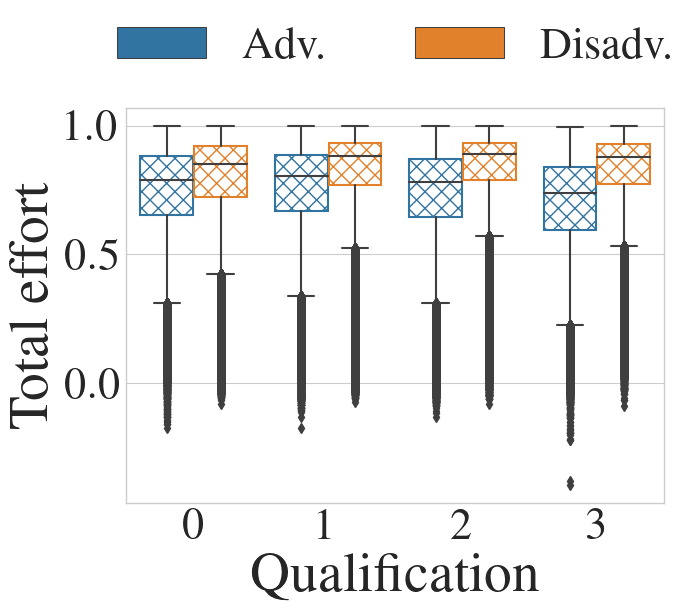

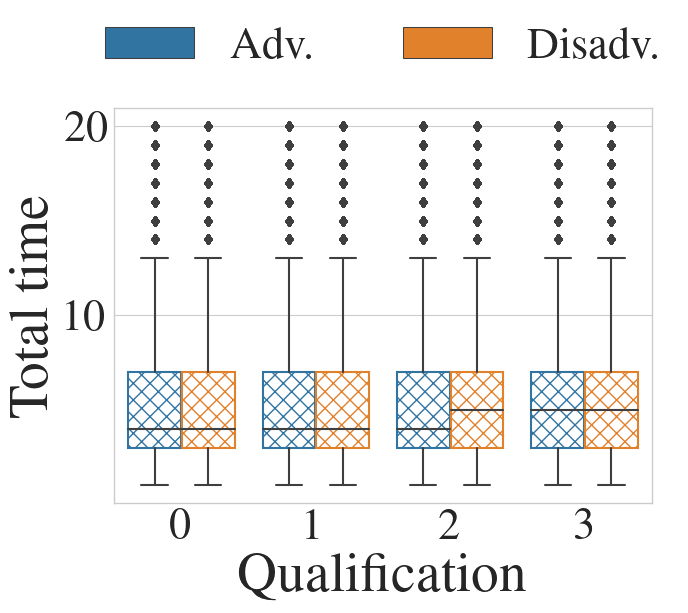

In [10]:
metrics_dfs = []
for params, environment in results:
    ai_etr = fairness_metrics_viz_data(environment)
    ai_etr["rng_seed"] = params["RNG_SEED"]
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")

sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"Fair_CDA_MM_B10_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()



ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"Fair_CDA_B10_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [11]:
mean_agents_data1 = agents_data_n_runs[
    ["rng_seed", "qualification", "groups", "time_for_recourse", "total_effort"]
].groupby(["rng_seed", "qualification", "groups"]).mean().reset_index()

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

metrics_per_init_and_qual1 = mean_agents_data1.groupby(["rng_seed", "qualification"]).apply(apply_transf).reset_index()
results_grouped = metrics_per_init_and_qual1.drop(columns="rng_seed").groupby("qualification")

means1 = results_grouped.mean()
sem1 = results_grouped.sem()
make_mean_sem_table(means1, sem1, decimals=3)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,-0.199 $\pm$ 0.013,1.064 $\pm$ 0.002
1,-0.127 $\pm$ 0.014,1.090 $\pm$ 0.001
2,-0.073 $\pm$ 0.016,1.127 $\pm$ 0.002
3,0.030 $\pm$ 0.019,1.175 $\pm$ 0.003


# EXP 2

In [12]:
BIAS_EFFORT2 = ([0, 1],) # [0, 0], 

In [13]:
results2 = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT2,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

  0%|          | 0/400 [00:00<?, ?it/s]

In [14]:
# fair_res = []
# for hyperparams, environment in results2:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

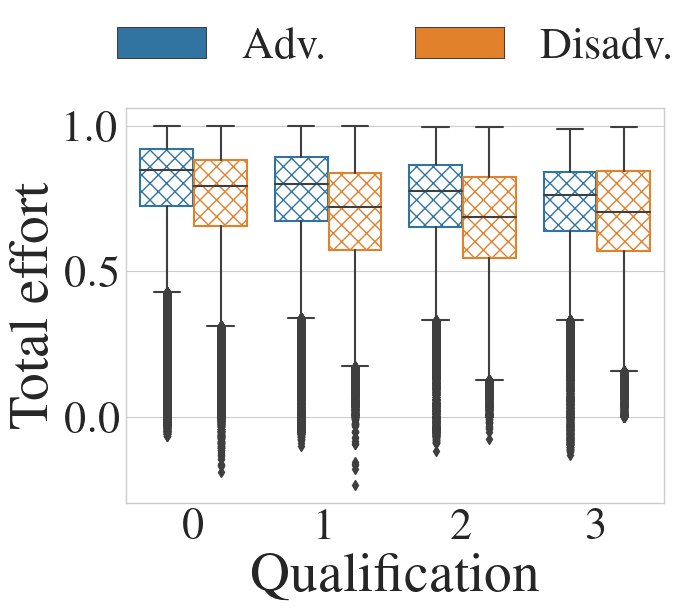

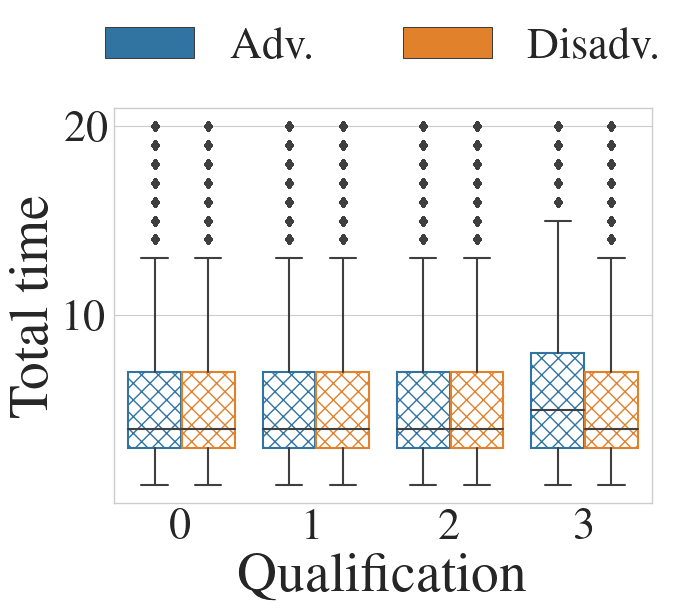

In [15]:
metrics_dfs = []
for params, environment in results2:
    ai_etr = fairness_metrics_viz_data(environment)
    ai_etr["rng_seed"] = params["RNG_SEED"]
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"Fair_CDA_MM_B01_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()



ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"Fair_CDA_MM_B01_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

In [16]:
mean_agents_data2 = agents_data_n_runs[
    ["rng_seed", "qualification", "groups", "time_for_recourse", "total_effort"]
].groupby(["rng_seed", "qualification", "groups"]).mean().reset_index()

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

metrics_per_init_and_qual2 = mean_agents_data2.groupby(["rng_seed", "qualification"]).apply(apply_transf).reset_index()
results_grouped = metrics_per_init_and_qual2.drop(columns="rng_seed").groupby("qualification")

means2 = results_grouped.mean()
sem2 = results_grouped.sem()
make_mean_sem_table(means2, sem2, decimals=3)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,0.181 $\pm$ 0.014,0.940 $\pm$ 0.001
1,0.182 $\pm$ 0.012,0.916 $\pm$ 0.004
2,0.046 $\pm$ 0.015,0.901 $\pm$ 0.005
3,-0.050 $\pm$ 0.013,0.951 $\pm$ 0.003


# EXP 3

In [17]:
BIAS_EFFORT3 = ([0, 0],)

In [18]:
results3 = parallel_loop(
    _meta_simulation, 
    list(product(
        N_AGENTS,
        N_CONTINUOUS,
        N_LOANS,
        BIAS_FACTOR,
        ADAPTATION,
        NEW_AGENTS,
        BIAS_EFFORT3,
        RNG_SEED,
    )),
    n_jobs=-1,
    progress_bar=True
)

  0%|          | 0/400 [00:00<?, ?it/s]

In [19]:
# fair_res = []
# for hyperparams, environment in results:
#     bias = hyperparams["BIAS_FACTOR"]
#     fairness_res = fairness_metrics(environment, filter_feature="groups", bins=10, advantaged_pop=1)
#     fairness_res["Merit"] = bias
#     fair_res.append(fairness_res)

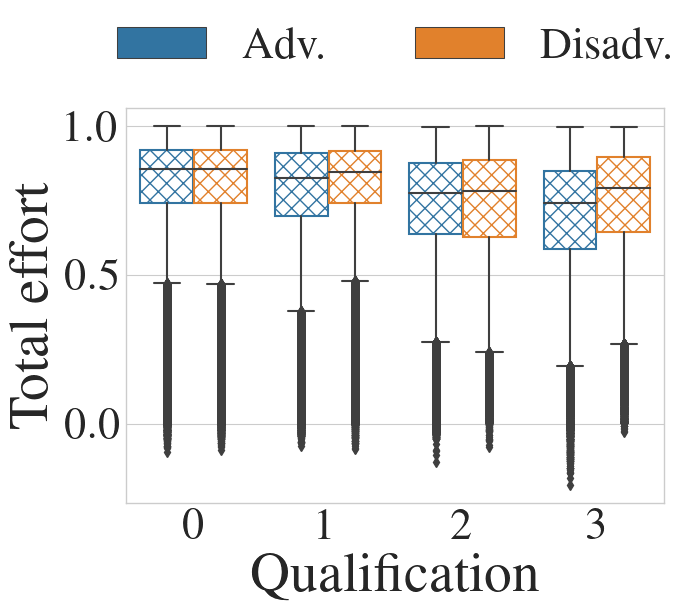

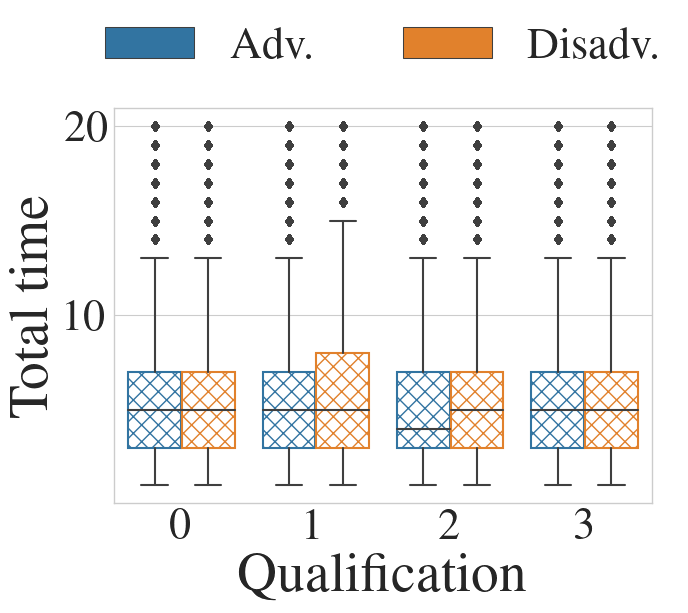

In [20]:
metrics_dfs = []
for params, environment in results3:
    ai_etr = fairness_metrics_viz_data(environment)
    ai_etr["rng_seed"] = params["RNG_SEED"]
    metrics_dfs.append((params, ai_etr))
    
ai_etrs_all = []
for bf in BIAS_FACTOR:
    ai_etrs = [df for p, df in metrics_dfs if p["BIAS_FACTOR"] == bf]
    ai_etrs = pd.concat(ai_etrs)
    ai_etrs["qualification"] = bf
    ai_etrs_all.append(ai_etrs)

agents_data_n_runs = pd.concat(ai_etrs_all)

agents_data_n_runs["groups2"] = agents_data_n_runs["groups"].apply(lambda x: "Adv." if x == 1 else "Disadv.")

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="total_effort", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total effort")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False
)
plt.savefig(
    f"Fair_CDA_MM_B00_total_effort.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

ax = sns.boxplot(data=agents_data_n_runs, x="qualification", y="time_for_recourse", hue="groups2")

hatches = ['//', 'xx'] # , 'xx']
# select the correct patches
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    # patch.set_hatch(hatch)
    patch.set_hatch("xx")
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor('none')

ax.set_xlabel("Qualification")
ax.set_ylabel("Total time")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
plt.savefig(
    f"Fair_CDA_MM_B00_time_for_recourse.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()


In [21]:
mean_agents_data3 = agents_data_n_runs[
    ["rng_seed", "qualification", "groups", "time_for_recourse", "total_effort"]
].groupby(["rng_seed", "qualification", "groups"]).mean().reset_index()

def apply_transf(df):
    df = df.set_index("groups")
    res_ = {}
    res_["time_to_recourse_difference"] = (df.loc[0, "time_for_recourse"] - df.loc[1, "time_for_recourse"])
    res_["effort_to_recourse_ratio"] = (df.loc[0, "total_effort"] / df.loc[1, "total_effort"])
    return pd.Series(res_)

metrics_per_init_and_qual3 = mean_agents_data3.groupby(["rng_seed", "qualification"]).apply(apply_transf).reset_index()
results_grouped = metrics_per_init_and_qual3.drop(columns="rng_seed").groupby("qualification")

means3 = results_grouped.mean()
sem3 = results_grouped.sem()
make_mean_sem_table(means3, sem3, decimals=3)

,time_to_recourse_difference,effort_to_recourse_ratio
qualification,,
0,0.004 $\pm$ 0.012,0.999 $\pm$ 0.001
1,0.226 $\pm$ 0.015,1.044 $\pm$ 0.002
2,0.220 $\pm$ 0.017,1.020 $\pm$ 0.005
3,0.021 $\pm$ 0.014,1.063 $\pm$ 0.004


# 1st PAGE VIZ - 

In [22]:
QUALIFICATION = 1

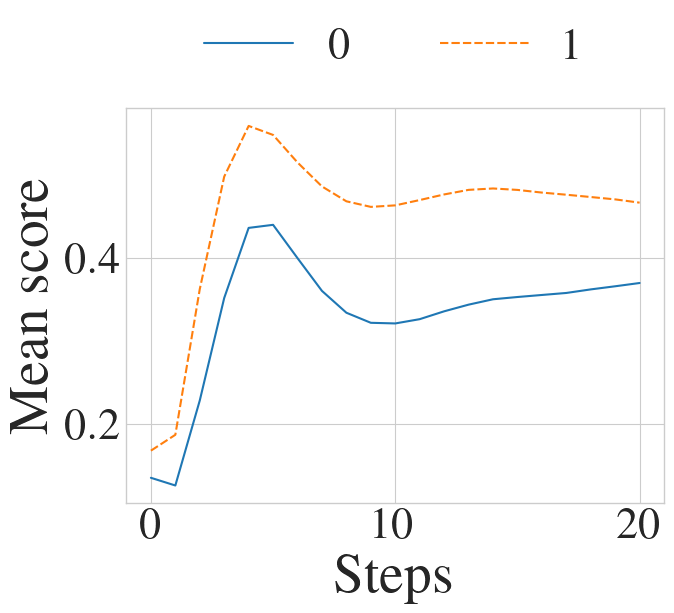

In [23]:
scores_dfs = []
for params, environment in results3:
    if params["BIAS_FACTOR"] == QUALIFICATION:
        scores = [ 
            pd.concat(
                [
                    environment.metadata_[step]["score"].rename("score"), 
                    environment.metadata_[step]["X"]["groups"],
                    pd.Series(np.ones(environment.metadata_[step]["score"].shape), name="step") * step
                ], 
                axis=1
            ).groupby("groups").mean()
            for step in environment.metadata_.keys()
        ]
        
        scores = pd.concat(scores).reset_index()
        scores["groups"] = scores["groups"].astype(int)
        scores["step"] = scores["step"].astype(int)
        scores = scores.pivot(index="step", columns="groups", values="score").reset_index()
        scores.columns.rename(None, inplace=True)
        scores_dfs.append(scores)
        
scores_dfs_exp1 = pd.DataFrame(np.mean(scores_dfs, axis=0), columns=scores_dfs[0].columns, index=scores_dfs[0].index)
scores_dfs_exp1["step"] = scores_dfs_exp1["step"].astype(int)
scores_dfs_exp1 = scores_dfs_exp1.set_index("step")
ax = sns.lineplot(scores_dfs_exp1)
ax.set_xlabel("Steps")
ax.set_ylabel("Mean score")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Draft

In [24]:
# initial demographic parity
def get_demographic_parity(results_list, time_step=0):
    initial_dem_parity = []
    for params, environment in results_list:
        counts = pd.concat([environment.metadata_[time_step]["X"]["groups"], environment.metadata_[time_step]["outcome"]], axis=1).groupby(["groups", 0]).size()

        prop_dis = counts[0., 1] / (counts[0., 1] + counts[0., 0])
        prop_adv = counts[1., 1] / (counts[1., 1] + counts[1., 0])
        initial_dem_parity.append((params["BIAS_FACTOR"], (prop_dis / prop_adv)))

    return pd.DataFrame(initial_dem_parity, columns=["bias_factor", "dem_parity"]).groupby("bias_factor").mean()


df_dp = []
for i in range(21):
    dem_parity = get_demographic_parity(results3, time_step=i).rename(columns={"dem_parity": i})
    df_dp.append(dem_parity)
    
df_dp = pd.concat(df_dp, axis=1).T

In [25]:
df_dp

bias_factor,0,1,2,3
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0
6,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0
9,1.0,1.0,1.0,1.0


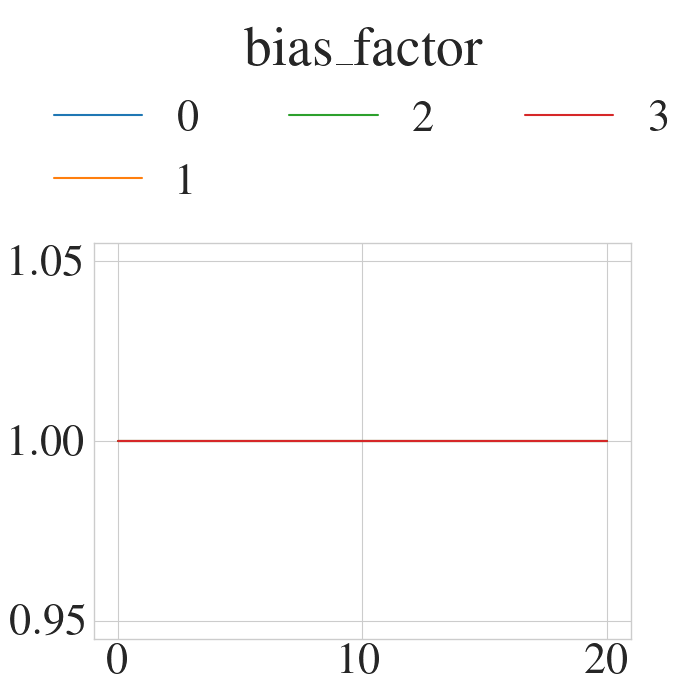

In [26]:
ax = df_dp.plot.line()
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3,# title=None, frameon=False,
)